In [1]:
import pandas as pd
import json
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080'

In [3]:
# Load the data
train_df = pd.read_csv("../data/train.csv")
train_df = train_df.set_index("id")
train_df.entities = train_df.entities.apply(json.loads)  # Parse entities
train_df.relations = train_df.relations.apply(json.loads)  # Parse relations

# Display the first few rows
train_df.head()

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{'id': 0, 'mentions': [{'value': 'accident', ...","[[0, STARTED_IN, 9], [7, IS_LOCATED_IN, 9], [5..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{'id': 0, 'mentions': [{'value': 'explosé', '...","[[9, IS_LOCATED_IN, 8], [11, OPERATES_IN, 8], ..."
51470,"En Espagne, dans une région agricole, une cont...","[{'id': 0, 'mentions': [{'value': 'contaminati...","[[7, IS_PART_OF, 8], [9, OPERATES_IN, 1], [0, ..."
51332,Un important incendie a fait des ravages dans ...,"[{'id': 0, 'mentions': [{'value': 'incendie', ...","[[12, IS_IN_CONTACT_WITH, 5], [0, IS_LOCATED_I..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{'id': 0, 'mentions': [{'value': 'renversé', ...","[[9, IS_LOCATED_IN, 2], [0, START_DATE, 17], [..."


In [ ]:
# 1. Get top 10 relation labels
all_relations = [rel[1] for row in train_df['relations'] for rel in row]
top_10_relations = [rel for rel, _ in Counter(all_relations).most_common(15)]
top_10_relations

['IS_LOCATED_IN',
 'HAS_CONTROL_OVER',
 'IS_IN_CONTACT_WITH',
 'OPERATES_IN',
 'STARTED_IN',
 'IS_AT_ODDS_WITH',
 'IS_PART_OF',
 'START_DATE',
 'GENDER_MALE',
 'HAS_CATEGORY',
 'END_DATE',
 'HAS_CONSEQUENCE',
 'INITIATED',
 'IS_OF_SIZE',
 'GENDER_FEMALE']

In [ ]:
# 2. Create entity type pairs with labels
data_points = []
for _, row in train_df.iterrows():
    entity_types = {e['id']: e['type'] for e in row['entities']}
    
    for rel in row['relations']:
        if rel[1] in top_10_relations:
            try:
                entity1_type = entity_types[rel[0]]
                entity2_type = entity_types[rel[2]]
                data_points.append({
                    'text': f"{entity1_type} [SEP] {entity2_type}",
                    'label': rel[1]
                })
            except KeyError:
                continue  #should not happen

In [6]:
data_points[:10]

[{'text': 'ACCIDENT [SEP] PLACE', 'label': 'STARTED_IN'},
 {'text': 'CIVILIAN [SEP] PLACE', 'label': 'IS_LOCATED_IN'},
 {'text': 'GROUP_OF_INDIVIDUALS [SEP] PLACE', 'label': 'IS_LOCATED_IN'},
 {'text': 'CIVILIAN [SEP] CIVILIAN', 'label': 'GENDER_FEMALE'},
 {'text': 'GROUP_OF_INDIVIDUALS [SEP] PLACE', 'label': 'IS_LOCATED_IN'},
 {'text': 'ACCIDENT [SEP] PLACE', 'label': 'IS_LOCATED_IN'},
 {'text': 'CIVILIAN [SEP] PLACE', 'label': 'IS_LOCATED_IN'},
 {'text': 'GROUP_OF_INDIVIDUALS [SEP] PLACE', 'label': 'IS_LOCATED_IN'},
 {'text': 'TERRORIST_OR_CRIMINAL [SEP] PLACE', 'label': 'IS_LOCATED_IN'},
 {'text': 'CIVILIAN [SEP] CATEGORY', 'label': 'HAS_CATEGORY'}]

In [7]:
# 3. Encode labels
le = LabelEncoder()
df_processed = pd.DataFrame(data_points)
df_processed['label'] = le.fit_transform(df_processed['label'])

In [8]:
# 4. Create dataset
dataset = Dataset.from_pandas(df_processed)
dataset = dataset.train_test_split(test_size=0.1)

In [9]:
# 5. Tokenize
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/26616 [00:00<?, ? examples/s]

Map:   0%|          | 0/2958 [00:00<?, ? examples/s]

In [10]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 26616
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2958
    })
})

In [11]:
tokenized_dataset['train'][0]

{'text': 'GROUP_OF_INDIVIDUALS [SEP] PLACE',
 'label': 9,
 'input_ids': [101,
  2177,
  1035,
  1997,
  1035,
  3633,
  102,
  2173,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [ ]:
# Check label encoding
print("Unique labels:", set(dataset['train']['label']))
print("Number of classes:", len(set(dataset['train']['label'])))


Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
Number of classes: 15


In [13]:
numeric_labels = dataset['train']['label']

# Reverse to class names
class_names = le.inverse_transform(numeric_labels)

print(set(class_names))

{'HAS_CONTROL_OVER', 'OPERATES_IN', 'END_DATE', 'START_DATE', 'GENDER_MALE', 'IS_LOCATED_IN', 'IS_OF_SIZE', 'IS_PART_OF', 'IS_IN_CONTACT_WITH', 'GENDER_FEMALE', 'HAS_CATEGORY', 'IS_AT_ODDS_WITH', 'INITIATED', 'STARTED_IN', 'HAS_CONSEQUENCE'}


In [14]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(le.classes_)
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    
    macro_f1 = f1.mean()
    
    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'precision': precision.tolist(),  # Per-class precision
        'recall': recall.tolist(),       # Per-class recall
        'f1': f1.tolist(),               # Per-class F1
    }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='steps',  # Evaluate every `eval_steps`
    eval_steps=500,               # Evaluate every 500 steps
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=2,          # Number of epochs to train for
    weight_decay=0.01,
    logging_dir='./logs',        # Directory for logs
    logging_steps=100,             # Log metrics every 10 steps
    load_best_model_at_end=True,  # Load the best model at the end
    metric_for_best_model='macro_f1',  # Use macro F1 to select the best model
    save_strategy='steps',        # Save checkpoints every `eval_steps`
    save_steps=1000,
)

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Precision,Recall,F1
500,0.686700,0.671467,0.704868,0.579499,"[0.5454545454545454, 0.0, 0.4484536082474227, 1.0, 1.0, 0.7300469483568075, 1.0, 0.0, 0.5328083989501312, 0.7420189818809318, 1.0, 0.23170731707317074, 0.9250936329588015, 0.0, 0.5473684210526316]","[0.06521739130434782, 0.0, 1.0, 1.0, 1.0, 0.6575052854122622, 1.0, 0.0, 0.66996699669967, 0.9988385598141696, 1.0, 0.12582781456953643, 1.0, 0.0, 0.9541284403669725]","[0.11650485436893204, 0.0, 0.6192170818505338, 1.0, 1.0, 0.6918798665183538, 1.0, 0.0, 0.5935672514619883, 0.8514851485148515, 1.0, 0.1630901287553648, 0.9610894941634242, 0.0, 0.6956521739130435]"
1000,0.610900,0.602708,0.719067,0.617929,"[0.0, 0.0, 0.4484536082474227, 1.0, 1.0, 1.0, 1.0, 0.42857142857142855, 0.6220095693779905, 0.7420189818809318, 1.0, 0.40522875816993464, 0.9250936329588015, 0.0, 0.5422885572139303]","[0.0, 0.0, 1.0, 1.0, 1.0, 0.5983086680761099, 1.0, 0.2746478873239437, 0.429042904290429, 0.9988385598141696, 1.0, 0.8211920529801324, 1.0, 0.0, 1.0]","[0.0, 0.0, 0.6192170818505338, 1.0, 1.0, 0.7486772486772487, 1.0, 0.33476394849785407, 0.5078125, 0.8514851485148515, 1.0, 0.5426695842450766, 0.9610894941634242, 0.0, 0.7032258064516129]"
1500,0.566100,0.594492,0.722448,0.607528,"[0.0, 0.0, 0.4484536082474227, 1.0, 1.0, 0.8172043010752689, 1.0, 0.45185185185185184, 0.5935672514619883, 0.7420189818809318, 1.0, 0.45, 0.9250936329588015, 0.0, 0.5422885572139303]","[0.0, 0.0, 1.0, 1.0, 1.0, 0.642706131078224, 1.0, 0.4295774647887324, 0.66996699669967, 0.9988385598141696, 1.0, 0.11920529801324503, 1.0, 0.0, 1.0]","[0.0, 0.0, 0.6192170818505338, 1.0, 1.0, 0.7195266272189349, 1.0, 0.4404332129963899, 0.6294573643410852, 0.8514851485148515, 1.0, 0.18848167539267016, 0.9610894941634242, 0.0, 0.7032258064516129]"
2000,0.556400,0.583593,0.733604,0.630740,"[0.0, 0.0, 0.4484536082474227, 1.0, 1.0, 1.0, 1.0, 0.45038167938931295, 0.5942028985507246, 0.7420189818809318, 1.0, 0.5538461538461539, 0.9250936329588015, 0.0, 0.5422885572139303]","[0.0, 0.0, 1.0, 1.0, 1.0, 0.5983086680761099, 1.0, 0.4154929577464789, 0.6765676567656765, 0.9988385598141696, 1.0, 0.4768211920529801, 1.0, 0.0, 1.0]","[0.0, 0.0, 0.6192170818505338, 1.0, 1.0, 0.7486772486772487, 1.0, 0.43223443223443225, 0.6327160493827161, 0.8514851485148515, 1.0, 0.5124555160142349, 0.9610894941634242, 0.0, 0.7032258064516129]"
2500,0.585500,0.590156,0.732928,0.631071,"[0.0, 0.0, 0.4484536082474227, 1.0, 1.0, 1.0, 1.0, 0.44680851063829785, 0.5922619047619048, 0.7420189818809318, 1.0, 0.5581395348837209, 0.9250936329588015, 0.0, 0.5422885572139303]","[0.0, 0.0, 1.0, 1.0, 1.0, 0.5983086680761099, 1.0, 0.44366197183098594, 0.6567656765676567, 0.9988385598141696, 1.0, 0.4768211920529801, 1.0, 0.0, 1.0]","[0.0, 0.0, 0.6192170818505338, 1.0, 1.0, 0.7486772486772487, 1.0, 0.4452296819787986, 0.622848200312989, 0.8514851485148515, 1.0, 0.5142857142857142, 0.9610894941634242, 0.0, 0.7032258064516129]"
3000,0.565500,0.579095,0.733942,0.630815,"[0.0, 0.0, 0.4484536082474227, 1.0, 1.0, 1.0, 1.0, 0.4634146341463415, 0.5859154929577465, 0.7420189818809318, 1.0, 0.5625, 0.9250936329588015, 0.0, 0.5422885572139303]","[0.0, 0.0, 1.0, 1.0, 1.0, 0.5983086680761099, 1.0, 0.4014084507042254, 0.6864686468646864, 0.9988385598141696, 1.0, 0.4768211920529801, 1.0, 0.0, 1.0]","[0.0, 0.0, 0.6192170818505338, 1.0, 1.0, 0.7486772486772487, 1.0, 0.43018867924528303, 0.6322188449848024, 0.8514851485148515, 1.0, 0.5161290322580645, 0.9610894941634242, 0.0, 0.7032258064516129]"


c:\Users\Natha\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natha\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natha\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

TrainOutput(global_step=3328, training_loss=0.6401908228603693, metrics={'train_runtime': 2925.9171, 'train_samples_per_second': 18.193, 'train_steps_per_second': 1.137, 'total_flos': 7053139361710080.0, 'train_loss': 0.6401908228603693, 'epoch': 2.0})

In [ ]:
# # 7. Save model and label encoder
model.save_pretrained('../my_distilbert_model_nREL10')
tokenizer.save_pretrained('../my_distilbert_model_nREL10')
pd.Series(le.classes_).to_csv('../my_distilbert_model_nREL10/label_encoder.csv', index=False)

In [19]:
# Evaluate on the test set
eval_results = trainer.evaluate(tokenized_dataset['test'])

# Print evaluation results
print("Evaluation Results:")
print(eval_results)


Evaluation Results:
{'eval_loss': 0.5792416930198669, 'eval_accuracy': 0.7319134550371873, 'eval_macro_f1': 0.6263256367646578, 'eval_precision': [0.0, 0.0, 0.4484536082474227, 1.0, 1.0, 1.0, 1.0, 0.44, 0.5687830687830688, 0.7420189818809318, 1.0, 0.5625, 0.9250936329588015, 0.0, 0.5422885572139303], 'eval_recall': [0.0, 0.0, 1.0, 1.0, 1.0, 0.5983086680761099, 1.0, 0.30985915492957744, 0.7095709570957096, 0.9988385598141696, 1.0, 0.4768211920529801, 1.0, 0.0, 1.0], 'eval_f1': [0.0, 0.0, 0.6192170818505338, 1.0, 1.0, 0.7486772486772487, 1.0, 0.36363636363636365, 0.631424375917768, 0.8514851485148515, 1.0, 0.5161290322580645, 0.9610894941634242, 0.0, 0.7032258064516129], 'eval_runtime': 48.2656, 'eval_samples_per_second': 61.286, 'eval_steps_per_second': 7.666, 'epoch': 2.0}


c:\Users\Natha\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


c:\Users\Natha\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


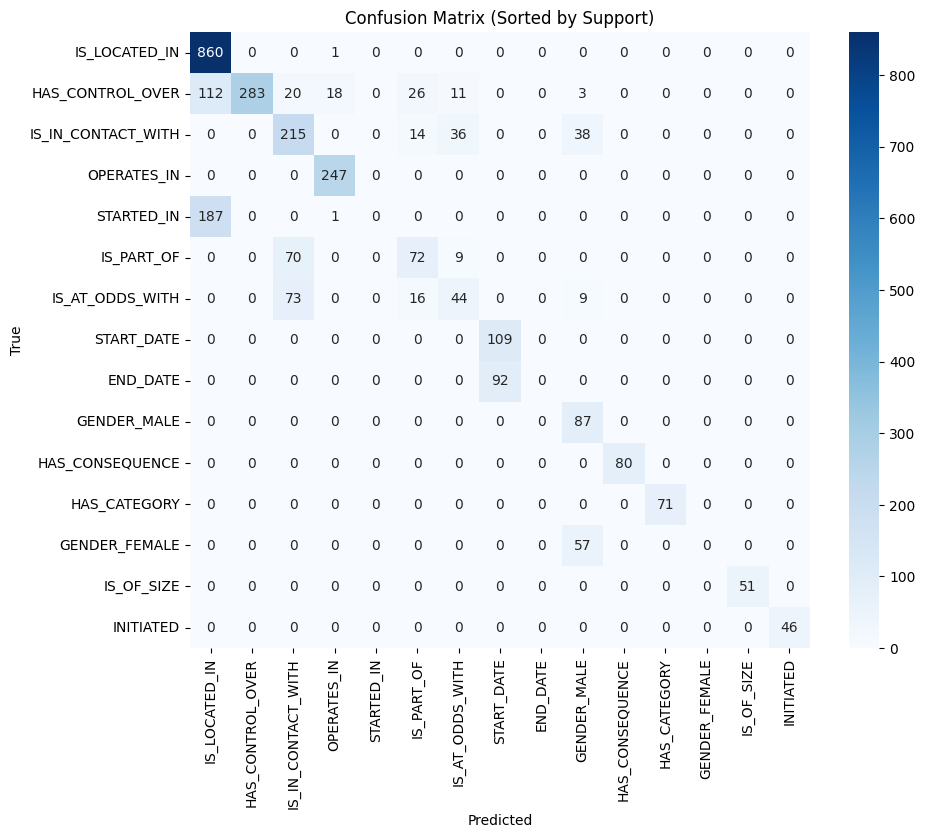

Classification Report (Sorted by Support):
                    precision    recall  f1-score   support

     IS_LOCATED_IN       0.74      1.00      0.85       861
  HAS_CONTROL_OVER       1.00      0.60      0.75       473
IS_IN_CONTACT_WITH       0.57      0.71      0.63       303
       OPERATES_IN       0.93      1.00      0.96       247
        STARTED_IN       0.00      0.00      0.00       188
        IS_PART_OF       0.56      0.48      0.52       151
   IS_AT_ODDS_WITH       0.44      0.31      0.36       142
        START_DATE       0.54      1.00      0.70       109
          END_DATE       0.00      0.00      0.00        92
       GENDER_MALE       0.45      1.00      0.62        87
   HAS_CONSEQUENCE       1.00      1.00      1.00        80
      HAS_CATEGORY       1.00      1.00      1.00        71
     GENDER_FEMALE       0.00      0.00      0.00        57
        IS_OF_SIZE       1.00      1.00      1.00        51
         INITIATED       1.00      1.00      1.00       

c:\Users\Natha\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natha\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natha\Desktop\TextMine25\env_textmine\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [ ]:
# Get predictions
predictions = trainer.predict(tokenized_dataset['test'])
pred_labels = predictions.predictions.argmax(axis=-1)
true_labels = predictions.label_ids

# Calculate support for each class
support = np.bincount(true_labels)

# Sort classes by support in descending order
sorted_indices = np.argsort(support)[::-1]
sorted_classes = np.array(le.classes_)[sorted_indices]
sorted_support = support[sorted_indices]

# Reorder true labels and predicted labels based on sorted classes
sorted_true_labels = np.array([sorted_indices.tolist().index(true_label) for true_label in true_labels])
sorted_pred_labels = np.array([sorted_indices.tolist().index(pred_label) for pred_label in pred_labels])

# Compute confusion matrix with sorted classes
cm = confusion_matrix(sorted_true_labels, sorted_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_classes, yticklabels=sorted_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Sorted by Support)')
plt.show()

# Generate classification report with sorted classes
class_report = classification_report(sorted_true_labels, sorted_pred_labels, target_names=sorted_classes, zero_division=0)
print("Classification Report (Sorted by Support):")
print(class_report)